In [1]:
import pandas as pd
import numpy as np
import gc
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler as SS
from sklearn.preprocessing import MinMaxScaler


from myutils import reduce_mem_usage

lentrain = 1503424
lentest = 508438
lentrainactive = 14129821
lentestactive = 12824068

categorical = ["user_id","region","city","parent_category_name","category_name","user_type","image_top_1","param_1","param_2","param_3"]
dropcols = ['Weekday']

In [2]:
def scale_standard(df, ignorecol=[]):
    cols = deepcopy(df.columns)
    for col in cols:
        #print(col)
        if (str(df[col].dtype)[:5] == 'float') and (not col in ignorecol):
            temp = SS().fit_transform(df[col].values.ravel().reshape(-1, 1))
            df[col] = temp.flatten()
    return df

def get_smalldiff(df1, df2, userate=0.2):
    assert (df1.columns == df2.columns).all(), 'inputs must have same columns'
    th = np.uint(df1.shape[1] * userate)
    criteria = {'mean': np.mean, 'var': np.var, 'median': np.median}
    difflist = []
    tempdiff = pd.DataFrame()
    tempdiff['colname'] = [col for col in df1.columns]
    for k, c in criteria.items():
        tempdiff[k] = [np.abs(c(df1[col]) - c(df2[col])) for col in df1.columns]
    tempdiff = scale_standard(tempdiff, ignorecol=['colname'])
    sums = np.zeros(tempdiff.shape[0])
    for key in criteria.keys():
        sums += np.abs(tempdiff[key])
    tempdiff['result'] = sums
    sortdiff = tempdiff.sort_values(by='result')
    print(sortdiff[['colname', 'result']])
    return sortdiff['colname'][: th].tolist()

def loadfeather(trpath, tepath, reader=pd.read_feather):
    train = reader(trpath)
    test = reader(tepath)
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)    
    df = pd.concat([train, test])
    del train, test; gc.collect()
    print(df.nunique())
    return df

def plothist(df):
    sidesplit = 3
    versplit = len(df.columns)//sidesplit + 1
    width = 4*sidesplit
    height = 3*versplit
    plt.figure(figsize=(width, height))
    for i, col in enumerate(df.columns):
        plt.subplot(versplit, sidesplit, i+1)
        plt.hist(df.iloc[:, i], label=col) 
        plt.legend()
    plt.show()

def plotcorr(df):
    colsize = len(df.columns)
    width = 6 + np.uint(colsize*0.2)
    height = 4 + np.uint(colsize*0.2)
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.set(style='white')
    f, ax = plt.subplots(figsize=(width, height))
    cmap = sns.diverging_palette(30, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5})
    
def concat2master(df, dfmaster):
    print(df.shape)
    #print(df.isnull().sum())
    df = reduce_mem_usage(df)
    #print(df.columns)
    #print(df.dtypes)
    for col in df.columns:
        dfmaster[col] = df[col]
    del df; gc.collect()
    print(dfmaster.shape)
    print(dfmaster.memory_usage().sum() / 1024**2, ' MB')
    return dfmaster

def scale_minmax(df, ignorecol=[]):
    cols = deepcopy(df.columns)
    for col in cols:
        if (str(df[col].dtype)[:3] == 'int') or (str(df[col].dtype)[:4] == 'uint'):
            print(col)
            temp = MinMaxScaler().fit_transform(df[col].values.ravel().reshape(-1, 1))
            df[col] = temp.flatten()
    return df

def choose_unique(df):
    print(f'before: {len(df.columns)}')
    uniques = {col: df[col].nunique() for col in df.columns}
    uniques_list = []
    for val in set(uniques.values()):
        temp = [k for k, v in uniques.items() if v == val]
        uniques_list.append(temp)
    uniques_list
    choiced = [str(np.random.choice(l, 1)[0]) for l in uniques_list]
    print(f'after: {len(choiced)}')
    return choiced

In [3]:
dfmaster = pd.DataFrame()

user_id                         1009909
region                               28
city                               1752
parent_category_name                  9
category_name                        47
param_1                             372
param_2                             278
param_3                            1277
price                             20761
item_seq_number                   33947
user_type                             3
image_top_1                        3064
Weekday                               7
desc_punc                           739
description_num_words               558
description_num_unique_words        353
description_words_vs_unique       12341
title_num_words                      17
title_num_unique_words               15
title_words_vs_unique                36
ridge_preds                     1954410
dtype: int64
user_id 1009909
region 28
city 1752
parent_category_name 9
category_name 47
user_type 3
image_top_1 3064
param_1 372
param_2 278
param_3 1277


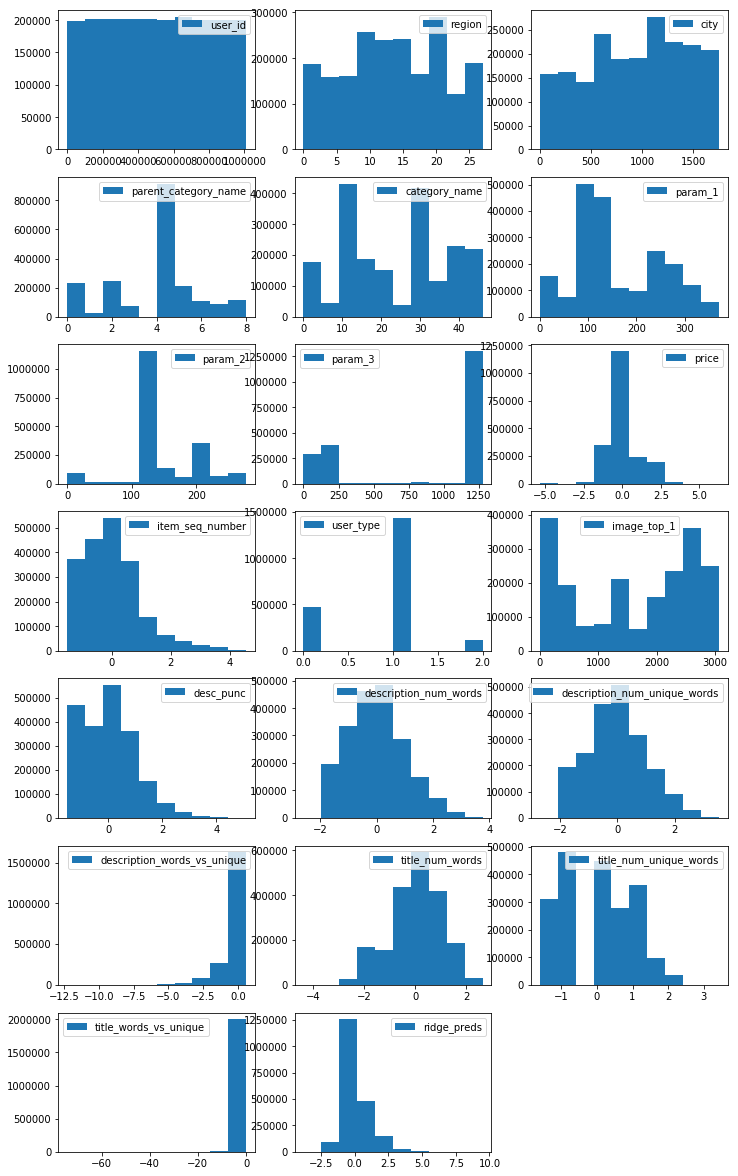

(2011862, 20)
Memory usage of dataframe is 322.34 MB
Memory usage after optimization is: 126.63 MB
Decreased by 60.7%
(2011862, 20)
126.63163375854492  MB


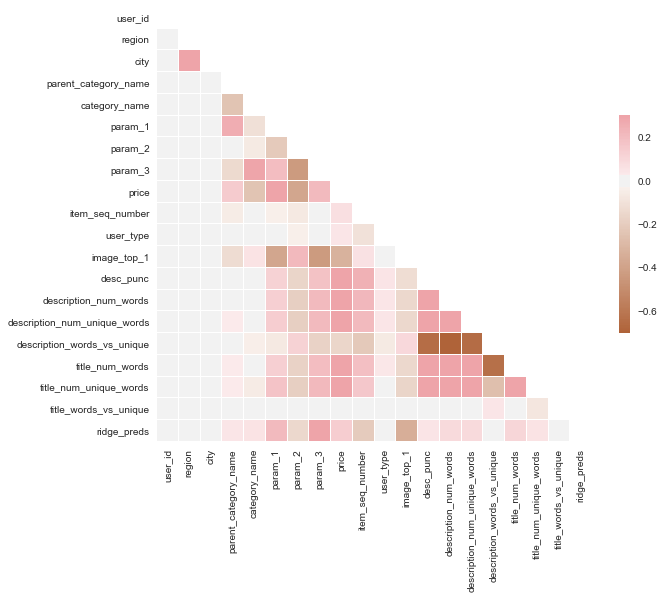

In [4]:
df = loadfeather('./kernel_train.feather', './kernel_test.feather')
for col in categorical:
    print(col, str(df[col].nunique()))
df['desc_punc'] = np.log1p(df['desc_punc'])
df['description_num_words'] = np.log1p(df['description_num_words'])
df['description_num_unique_words'] = np.log1p(df['description_num_unique_words'])
df['title_num_words'] = np.log1p(df['description_num_words'])
df['title_num_unique_words'] = np.log1p(df['title_num_unique_words'])
df['description_words_vs_unique'].fillna(df['description_words_vs_unique'].mean(), inplace=True)
df['item_seq_number'] = np.log1p(df['item_seq_number'])

df.drop(dropcols, axis=1, inplace=True)
df = scale_standard(df, ignorecol=categorical)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

avg_days_up_user         17413
avg_times_up_user         7204
avg_headdays_up_user     29551
n_user_items               956
avg_price_up_user       161337
var_price_up_user       309985
dtype: int64


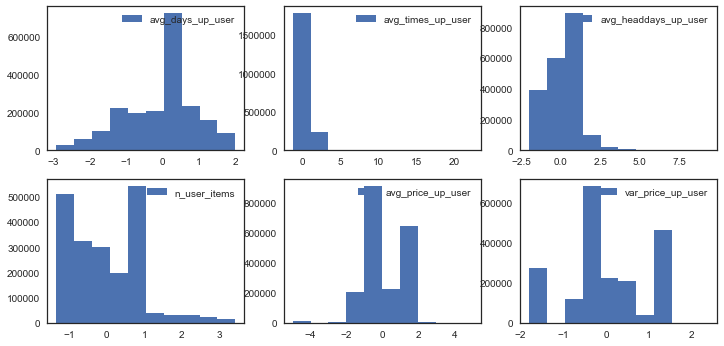

                colname    result
4     avg_price_up_user  2.157388
3          n_user_items  2.369647
1     avg_times_up_user  2.633943
0      avg_days_up_user  2.708459
5     var_price_up_user  2.797616
2  avg_headdays_up_user  4.140698
(2011862, 6)
Memory usage of dataframe is 61.40 MB
Memory usage after optimization is: 61.40 MB
Decreased by 0.0%
(2011862, 26)
172.67950057983398  MB


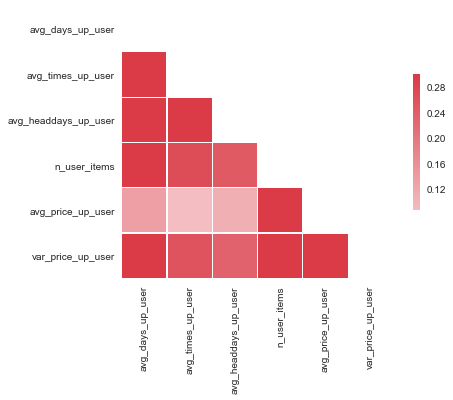

In [5]:
# User Data Agg
df = loadfeather('../features/train/Agg_User_train.feather', '../features/test/Agg_User_test.feather')
df['n_user_items'] = np.log1p(df['n_user_items'])
df['avg_price_up_user'] = np.log(df['avg_price_up_user']+0.001)
df['var_price_up_user'] = np.log(df['var_price_up_user']+0.001)
df = scale_standard(df)
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)


title_titleword_count                   15
title_upper_case_word_count             15
title_num_stopwords                     10
title_num_punctuations                  19
title_num_alphabets                      1
title_num_digits                         1
title_num_chars                         51
title_num_words                         17
title_num_unique_words                  15
title_chars_by_words                   285
title_words_by_uniquewords              42
title_punctuations_by_chars            260
title_punctuations_by_words            109
title_digits_by_chars                    1
title_alphabets_by_chars                 1
title_stopwords_by_words                49
title_mean                             282
description_titleword_count            226
description_upper_case_word_count      212
description_num_stopwords              151
description_num_punctuations           739
description_num_alphabets                2
description_num_digits                   1
description

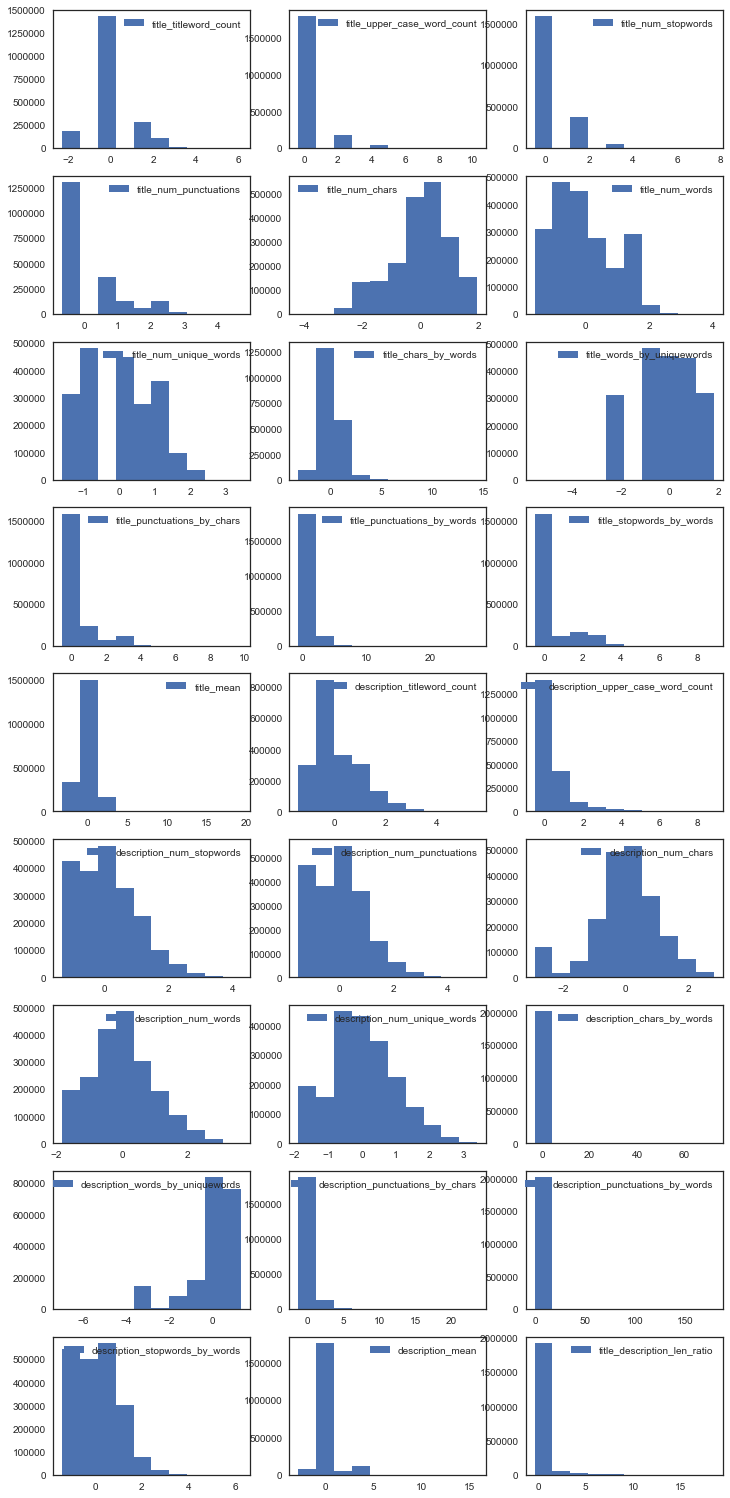

                              colname    result
22  description_punctuations_by_chars  1.185927
15          description_num_stopwords  1.251768
14  description_upper_case_word_count  1.328459
13        description_titleword_count  1.336173
23  description_punctuations_by_words  1.407820
19       description_num_unique_words  1.740240
1         title_upper_case_word_count  1.768018
8          title_words_by_uniquewords  1.957222
5                     title_num_words  1.987111
6              title_num_unique_words  1.987129
0               title_titleword_count  1.991918
4                     title_num_chars  2.006135
9         title_punctuations_by_chars  2.009514
3              title_num_punctuations  2.081599
12                         title_mean  2.106978
11           title_stopwords_by_words  2.115404
7                title_chars_by_words  2.167480
2                 title_num_stopwords  2.175166
10        title_punctuations_by_words  2.207745
17              description_num_chars  2

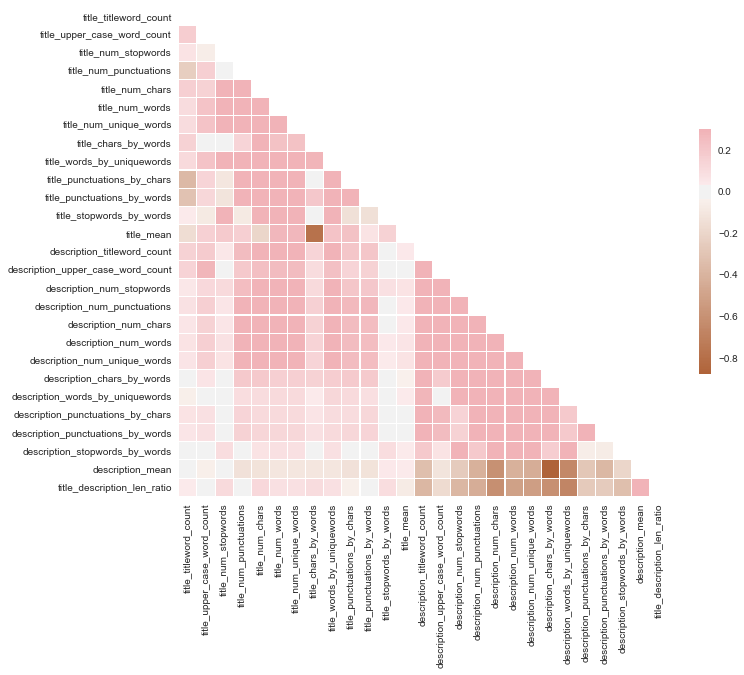

In [6]:
# Text features
df = loadfeather('../features/train/textfeatures_train.feather', '../features/test/textfeatures_test.feather')
for col in df.columns:
    col_spl = col.split('_')
    #print(col, df[col].min(), df[col].max())
    if col_spl[-1] == 'count' or col_spl[-2] == 'num' or col.count('num_unique_words'):
        df[col] = np.log1p(df[col])
        df[col] = df[col].astype('float32')

# 意味のないcolは落とす
droplist = ['title_num_alphabets', 'title_num_digits', 'description_num_digits', 'description_num_alphabets',
            'title_digits_by_chars', 'title_alphabets_by_chars', 'description_digits_by_chars', 'description_alphabets_by_chars']
df = df.drop(droplist, axis=1)
df = scale_standard(df)

plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)

city-parent_category_name-param_123_numunique                     780
region-city-category_name-param_1_numunique                       148
category_name-user_type-param_1-param_123_numunique                64
region-param_123_numunique                                         54
region-city-parent_category_name-param_123_numunique              780
category_name-user_type-param_1-city_numunique                   1099
region-city-user_type_numunique                                     8
region-parent_category_name-param_123-category_name_numunique      16
region-city-parent_category_name_numunique                         17
region-parent_category_name-param_123_numunique                   160
city-param_123-category_name_numunique                             92
city-param_1-param_123-category_name_numunique                     92
region-city-param_1-param_123_numunique                           588
region-city-param_123-user_type_numunique                           8
region-user_type-cit

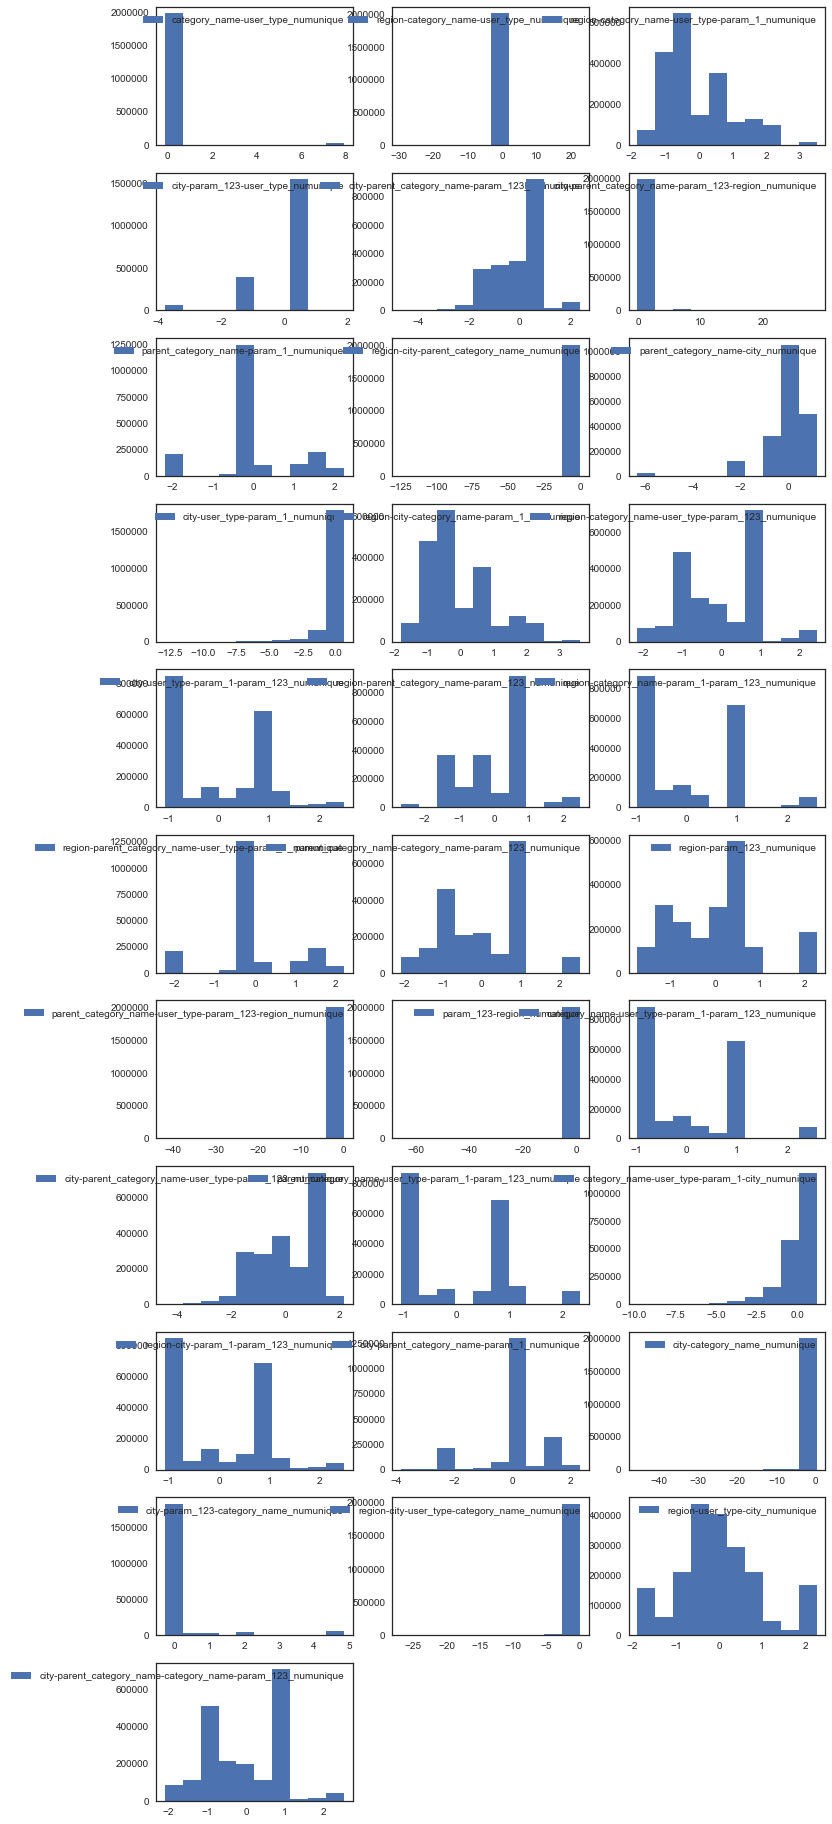

                                              colname    result
20  category_name-user_type-param_1-param_123_numu...  1.060470
3                  city-param_123-user_type_numunique  1.070651
23     category_name-user_type-param_1-city_numunique  1.079825
12         city-user_type-param_1-param_123_numunique  1.173450
28      region-city-user_type-category_name_numunique  1.282752
25        city-parent_category_name-param_1_numunique  1.293800
9                    city-user_type-param_1_numunique  1.314677
30  city-parent_category_name-category_name-param_...  1.428514
17                         region-param_123_numunique  1.557687
18  parent_category_name-user_type-param_123-regio...  1.645472
8                 parent_category_name-city_numunique  1.660126
6              parent_category_name-param_1_numunique  1.701089
15  region-parent_category_name-user_type-param_1_...  1.711191
5   city-parent_category_name-param_123-region_num...  1.852428
14   region-category_name-param_1-param_

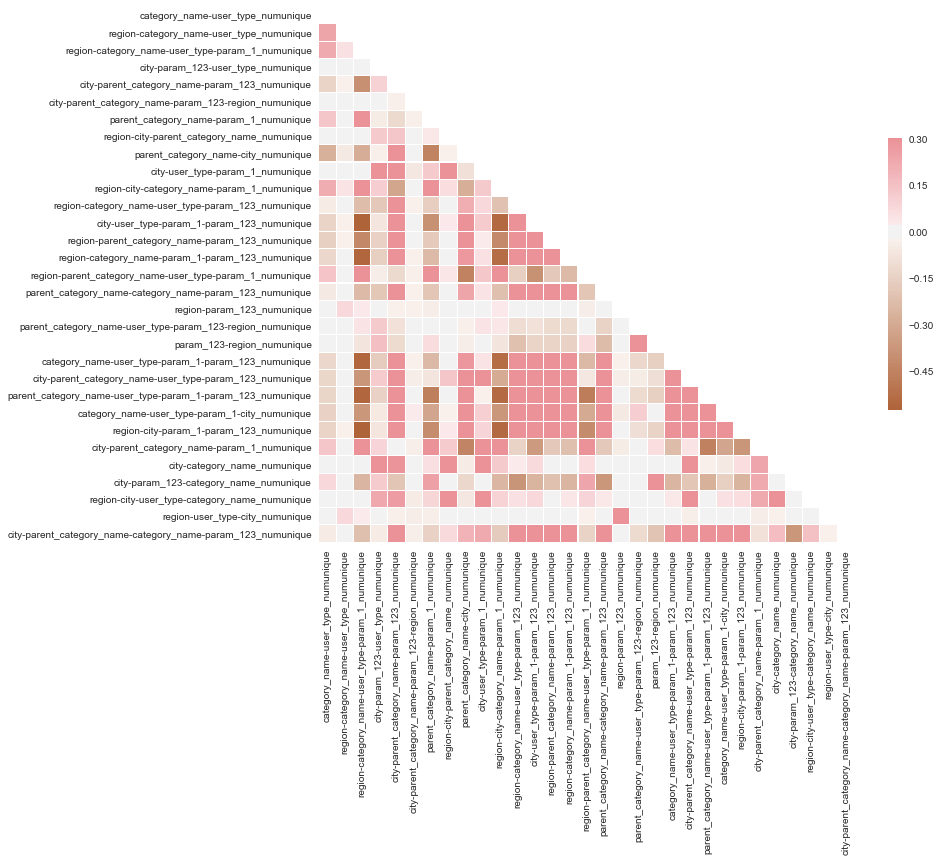

In [7]:
# Unique
df = loadfeather('../features/train/Agg_Unique_Silver_train.feather', '../features/test/Agg_Unique_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)

region-user_type_numcount                                           168
param_1-param_123_numcount                                         2656
param_123_numcount                                                 2656
parent_category_name-user_type-weekofday-param_1_numcount          3944
region-city-weekofday_numcount                                     3472
city-parent_category_name_numcount                                 4592
city-weekofday_numcount                                            3475
region-parent_category_name-user_type-param_1_numcount             7398
region-user_type-param_1_numcount                                  7077
parent_category_name-category_name-param_1-param_123_numcount      2760
parent_category_name-category_name-param_123_numcount              2760
category_name-param_1-param_123_numcount                           2760
category_name-param_123_numcount                                   2760
region-user_type-weekofday_numcount                             

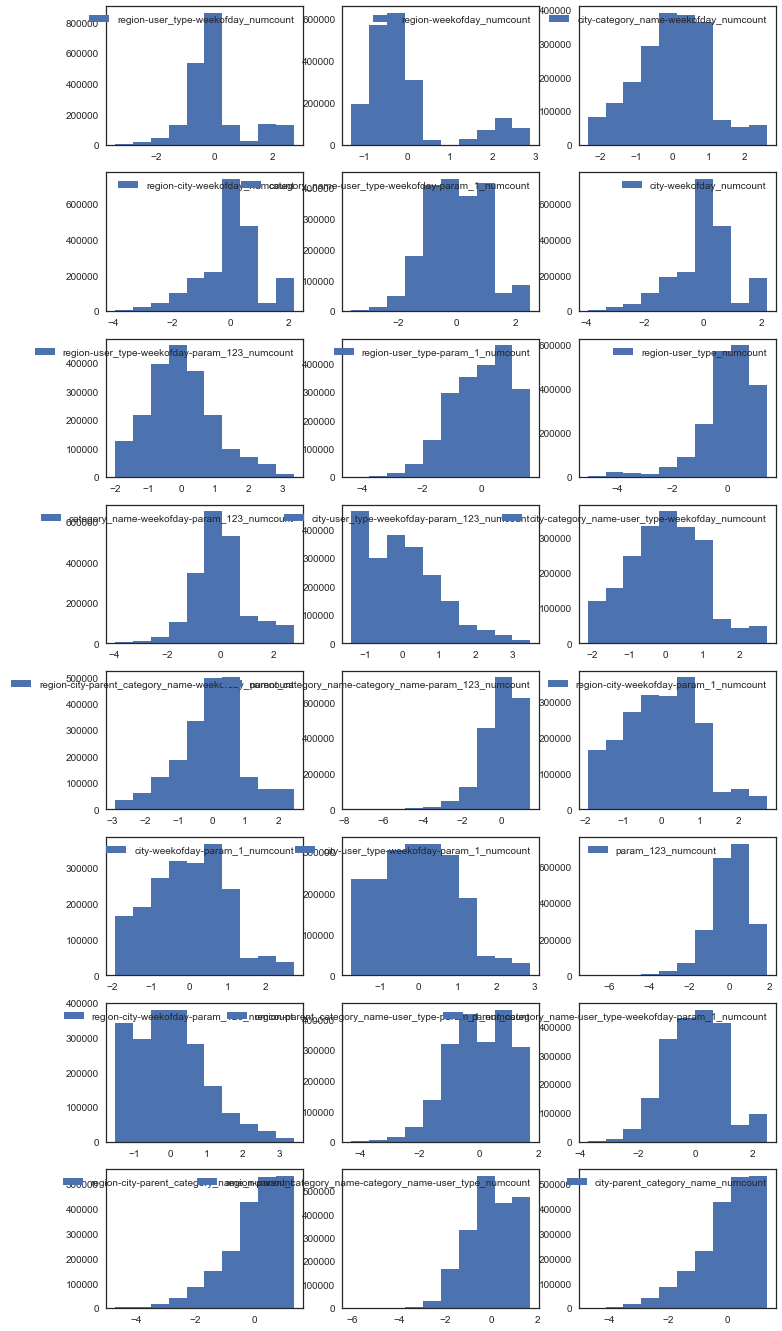

                                              colname    result
17                                 param_123_numcount  0.627427
5                             city-weekofday_numcount  0.698775
0                 region-user_type-weekofday_numcount  1.191282
20  parent_category_name-user_type-weekofday-param...  1.391917
2               city-category_name-weekofday_numcount  1.565391
15                    city-weekofday-param_1_numcount  1.596486
11    city-category_name-user_type-weekofday_numcount  1.602233
19  region-parent_category_name-user_type-param_1_...  1.774842
8                           region-user_type_numcount  1.985658
14             region-city-weekofday-param_1_numcount  2.031120
3                      region-city-weekofday_numcount  2.174191
9          category_name-weekofday-param_123_numcount  2.185551
16          city-user_type-weekofday-param_1_numcount  2.275061
13  parent_category_name-category_name-param_123_n...  2.299352
22  region-parent_category_name-category

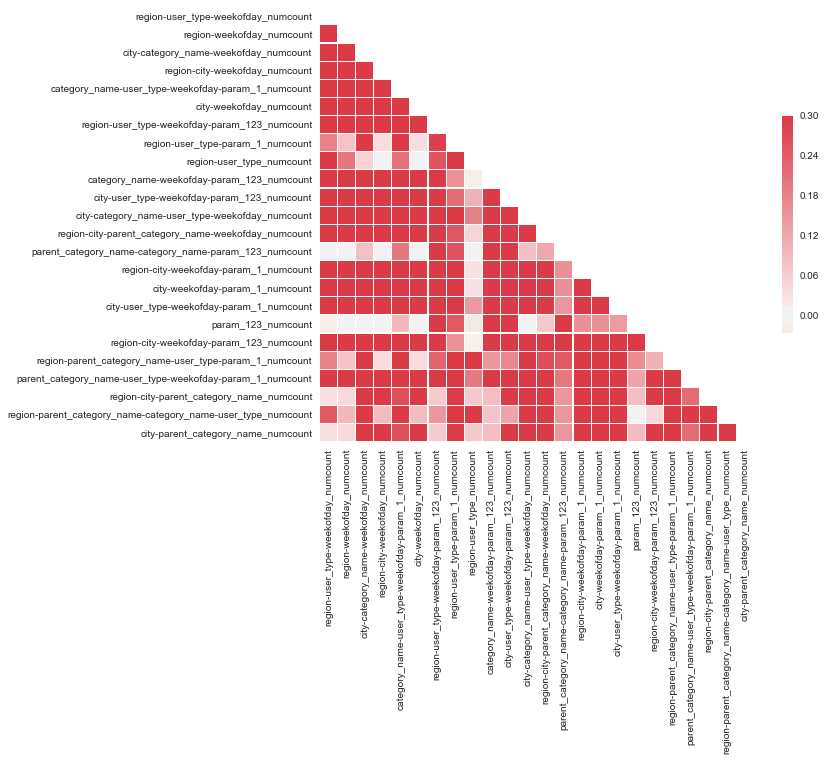

In [8]:
# Count Agg

df = loadfeather('../features/train/Agg_Count_Silver_train.feather', '../features/test/Agg_Count_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)


In [9]:
# Agg Price Silver Mean
'''
df = loadfeather('../features/train/Agg_Price_mean_Silver_train.feather', '../features/test/Agg_Price_mean_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Price_mean_Silver_train.feather', '../features/test/Agg_Price_mean_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [10]:
# Agg Price Silver Var
'''
df = loadfeather('../features/train/Agg_Price_var_Silver_train.feather', '../features/test/Agg_Price_var_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Price_var_Silver_train.feather', '../features/test/Agg_Price_var_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [11]:
# Agg Price Silver Median
'''
df = loadfeather('../features/train/Agg_Price_median_Silver_train.feather', '../features/test/Agg_Price_median_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Price_median_Silver_train.feather', '../features/test/Agg_Price_median_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [12]:
# Agg Item Silver mean
'''
df = loadfeather('../features/train/Agg_Itemseq_mean_Silver_train.feather', '../features/test/Agg_Itemseq_mean_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Itemseq_mean_Silver_train.feather', '../features/test/Agg_Itemseq_mean_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [13]:
# Agg Itemseq Silver Var
'''
df = loadfeather('../features/train/Agg_Itemseq_var_Silver_train.feather', '../features/test/Agg_Itemseq_var_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Itemseq_var_Silver_train.feather', '../features/test/Agg_Itemseq_var_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [14]:
# Agg Itemseq Silver Median
'''
df = loadfeather('../features/train/Agg_Itemseq_median_Silver_train.feather', '../features/test/Agg_Itemseq_median_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Itemseq_median_Silver_train.feather', '../features/test/Agg_Itemseq_median_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [15]:
# Agg Nunique Silver
'''
df = loadfeather('../features/train/Agg_Unique_Silver_train.feather', '../features/test/Agg_Unique_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Unique_Silver_train.feather', '../features/test/Agg_Unique_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [16]:
# Agg Imagetop Mean
'''
df = loadfeather('../features/train/Agg_Imagetop1_mean_Silver_train.feather', '../features/test/Agg_Imagetop1_mean_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Imagetop1_mean_Silver_train.feather', '../features/test/Agg_Imagetop1_mean_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

user_type-param_1-image_top_1-var                                           1854
parent_category_name-category_name-user_type-weekofday-image_top_1-var      1948
category_name-user_type-weekofday-image_top_1-var                           1948
city-parent_category_name-category_name-image_top_1-var                    36542
city-category_name-image_top_1-var                                         36542
parent_category_name-user_type-weekofday-param_1-image_top_1-var           10870
region-user_type-param_1-image_top_1-var                                   27882
region-category_name-user_type-image_top_1-var                              7171
region-parent_category_name-category_name-user_type-image_top_1-var         7171
region-user_type-weekofday-param_1-image_top_1-var                         89614
category_name-user_type-param_123-image_top_1-var                           7764
parent_category_name-category_name-user_type-param_123-image_top_1-var      7764
category_name-user_type-para

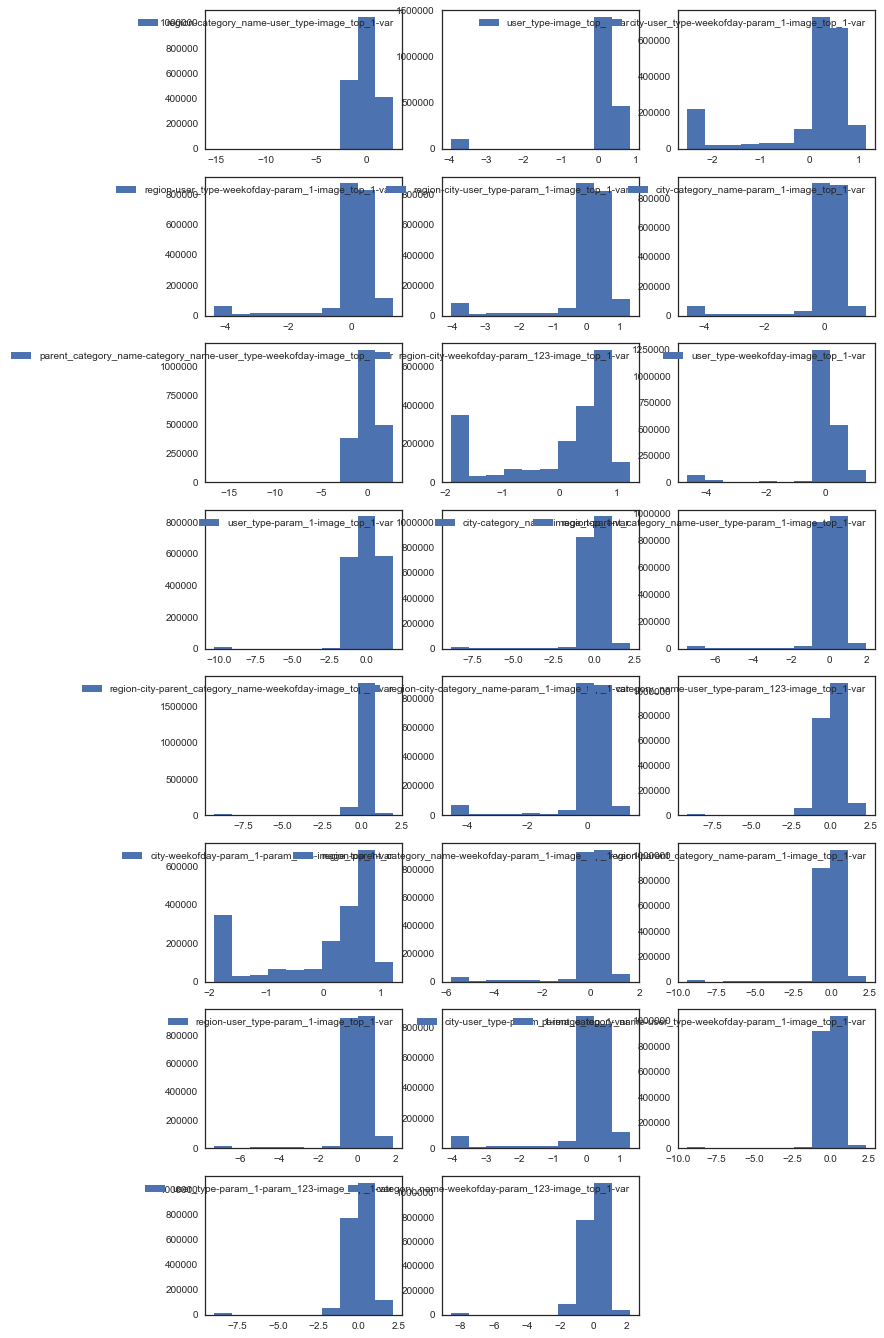

                                              colname    result
9                   user_type-param_1-image_top_1-var  0.588302
10                 city-category_name-image_top_1-var  0.690022
6   parent_category_name-category_name-user_type-w...  1.360658
18           region-user_type-param_1-image_top_1-var  1.454491
20  parent_category_name-user_type-weekofday-param...  1.582053
14  category_name-user_type-param_123-image_top_1-var  1.713876
15   city-weekofday-param_1-param_123-image_top_1-var  1.999232
3   region-user_type-weekofday-param_1-image_top_1...  2.006930
12  region-city-parent_category_name-weekofday-ima...  2.017069
2    city-user_type-weekofday-param_1-image_top_1-var  2.130664
7     region-city-weekofday-param_123-image_top_1-var  2.147355
4       region-city-user_type-param_1-image_top_1-var  2.170963
19             city-user_type-param_1-image_top_1-var  2.172892
21        user_type-param_1-param_123-image_top_1-var  2.264548
17  region-parent_category_name-param_1-

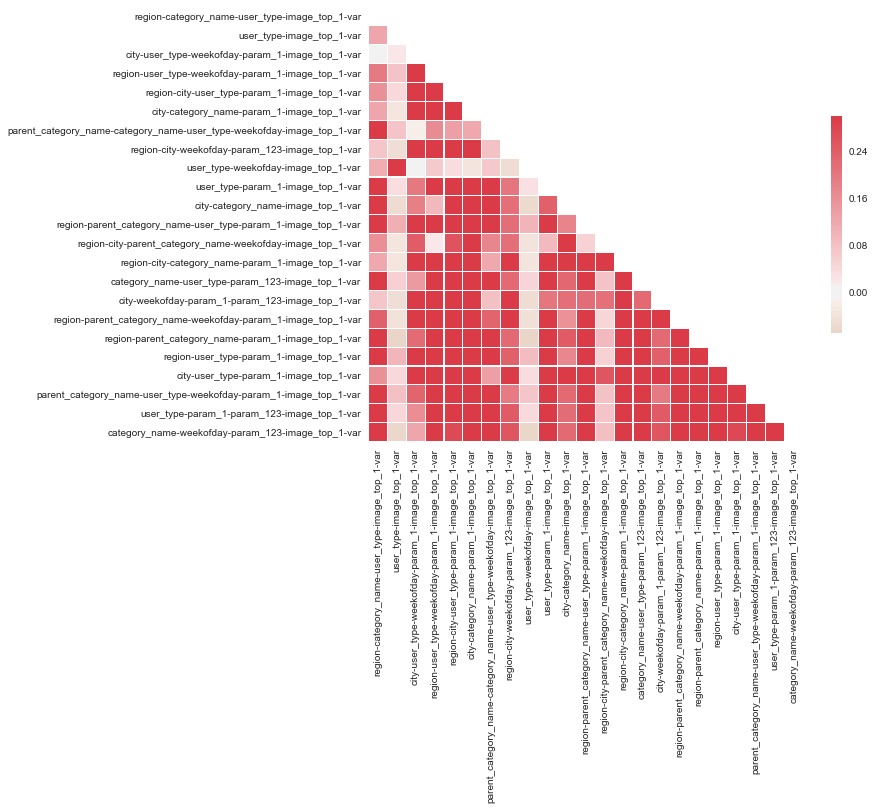

In [17]:
# Agg Imagetop Var

df = loadfeather('../features/train/Agg_Imagetop1_var_Silver_train.feather', '../features/test/Agg_Imagetop1_var_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)


city-category_name-user_type-param_123-image_top_1-median                    11464
region-city-parent_category_name-category_name-image_top_1-median             7794
region-city-category_name-image_top_1-median                                  7794
region-parent_category_name-category_name-param_1-image_top_1-median          4163
region-category_name-param_1-image_top_1-median                               4163
category_name-user_type-weekofday-param_1-image_top_1-median                  3566
region-image_top_1-median                                                       56
region-user_type-weekofday-image_top_1-median                                  676
city-category_name-weekofday-param_123-image_top_1-median                    11935
parent_category_name-category_name-user_type-param_123-image_top_1-median     2191
category_name-user_type-param_123-image_top_1-median                          2191
category_name-user_type-param_1-param_123-image_top_1-median                  2191
pare

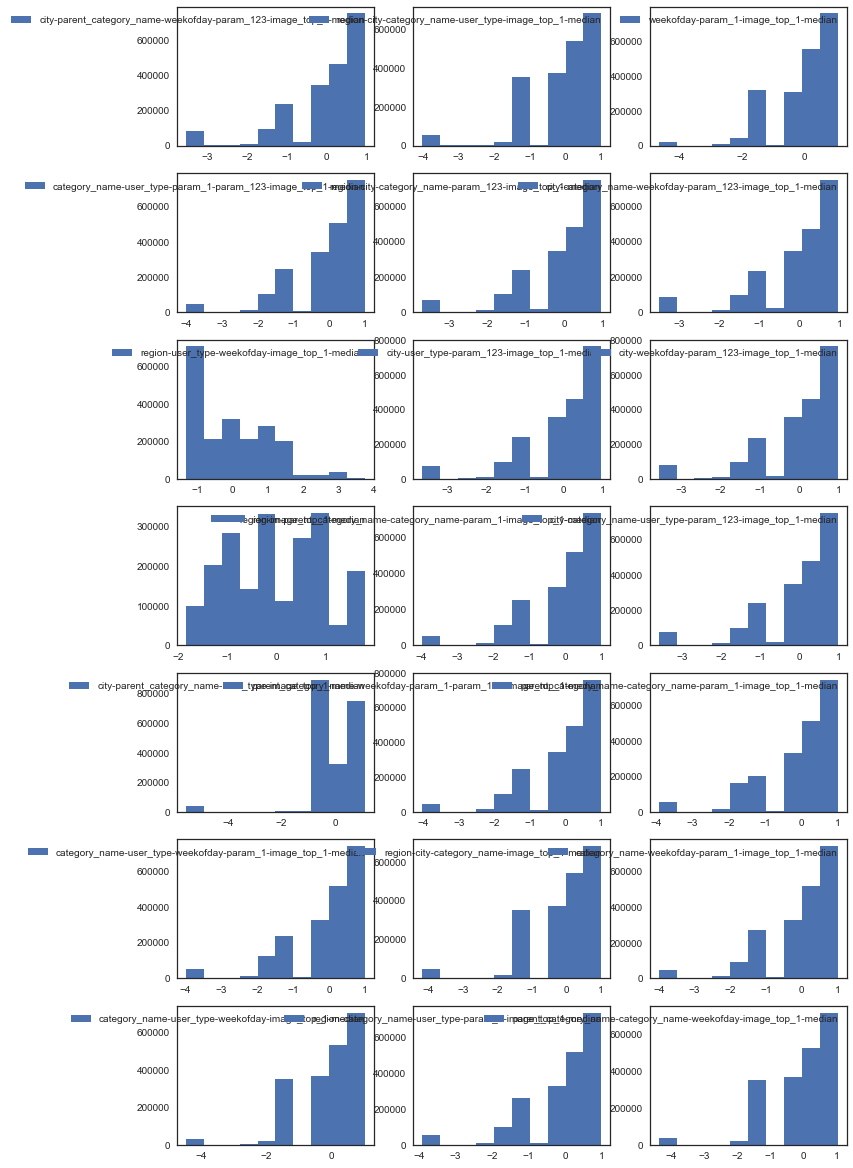

                                              colname    result
11  city-category_name-user_type-param_123-image_t...  0.208336
15  category_name-user_type-weekofday-param_1-imag...  1.176495
10  region-parent_category_name-category_name-para...  1.891279
16       region-city-category_name-image_top_1-median  2.049531
5   city-category_name-weekofday-param_123-image_t...  2.076635
3   category_name-user_type-param_1-param_123-imag...  2.120960
20  parent_category_name-category_name-weekofday-i...  2.283395
18  category_name-user_type-weekofday-image_top_1-...  2.392978
2                weekofday-param_1-image_top_1-median  2.477755
1   region-city-category_name-user_type-image_top_...  2.522456
0   city-parent_category_name-weekofday-param_123-...  2.523221
9                           region-image_top_1-median  2.643169
19  region-category_name-user_type-param_1-image_t...  2.716424
7         city-user_type-param_123-image_top_1-median  2.799416
14  parent_category_name-category_name-p

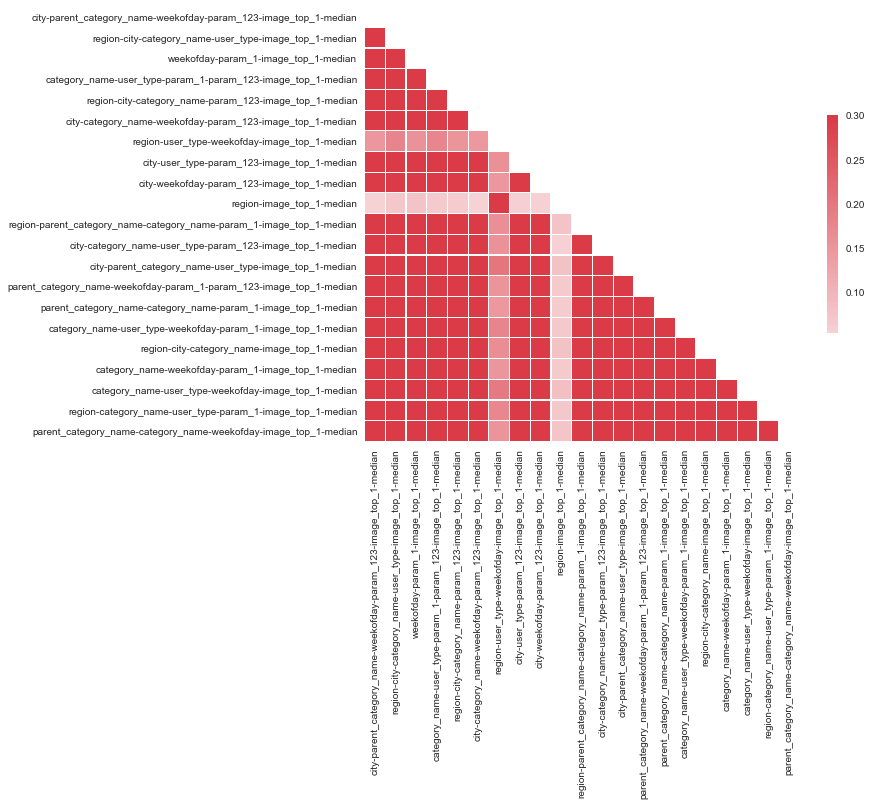

In [18]:
# Agg Imagetop Median

df = loadfeather('../features/train/Agg_Imagetop1_median_Silver_train.feather', '../features/test/Agg_Imagetop1_median_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)


imagefeatures__dullness                 20000
imagefeatures__whiteness                19999
imagefeatures__average_pixel_width     385129
imagefeatures__image_size               91662
imagefeatures__blurrness              1800693
imagefeatures__average_red            1728771
imagefeatures__average_green          1707081
imagefeatures__average_blue           1702035
imagefeatures__width                      609
imagefeatures__height                     452
dtype: int64
imagefeatures__image_size
imagefeatures__width
imagefeatures__height


C:\Users\ahega\Anaconda3\envs\Avito18_Kaggle\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ahega\Anaconda3\envs\Avito18_Kaggle\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


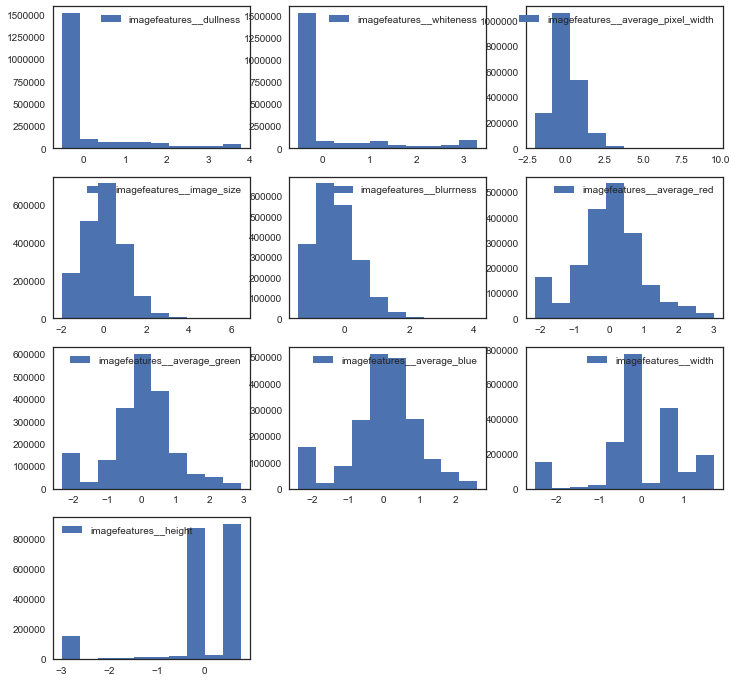

(2011862, 10)
Memory usage of dataframe is 115.12 MB
Memory usage after optimization is: 92.10 MB
Decreased by 20.0%
(2011862, 158)
1185.7325706481934  MB


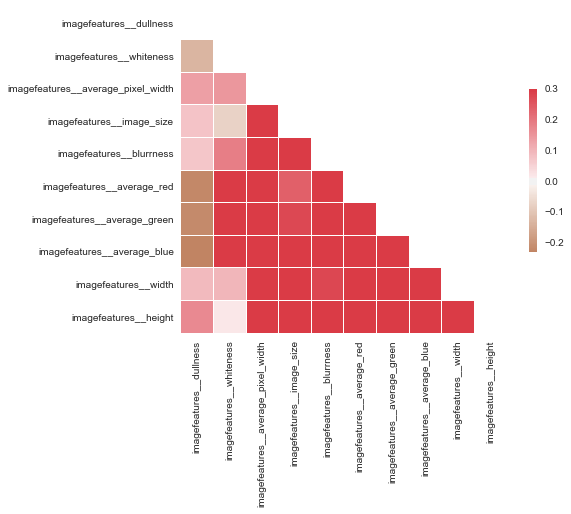

In [19]:
# Image Features
df = loadfeather('../features/train/imagefeatures_train.feather', '../features/test/imagefeatures_test.feather')
df = scale_minmax(df)
df = scale_standard(df)
df['imagefeatures__blurrness'] = np.log1p(df['imagefeatures__blurrness'])
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

imagenet_Resnet50_top1    1737109
imagenet_Resnet50_top2    1790338
imagenet_Resnet50_top3    1793828
dtype: int64


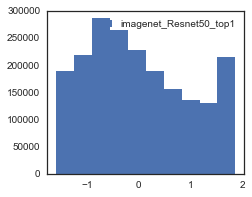

(2011862, 1)
Memory usage of dataframe is 30.70 MB
Memory usage after optimization is: 23.02 MB
Decreased by 25.0%
(2011862, 159)
1193.4072151184082  MB
imagenet_IndeptionV3_top1     579634
imagenet_IndeptionV3_top2    1725460
imagenet_IndeptionV3_top3    1728988
dtype: int64


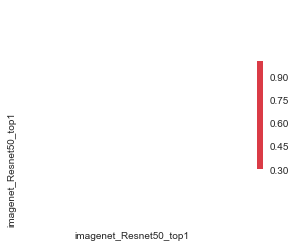

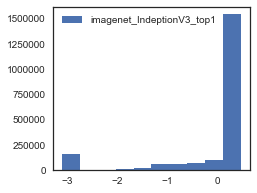

(2011862, 1)
Memory usage of dataframe is 30.70 MB
Memory usage after optimization is: 23.02 MB
Decreased by 25.0%
(2011862, 160)
1201.081859588623  MB
imagenet_Xception_top1    1085618
imagenet_Xception_top2    1823811
imagenet_Xception_top3    1828911
dtype: int64


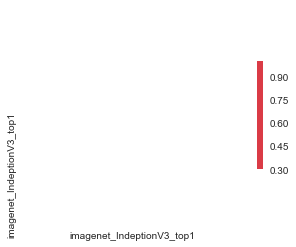

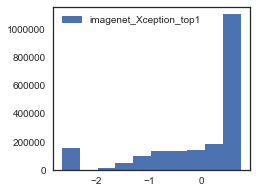

(2011862, 1)
Memory usage of dataframe is 30.70 MB
Memory usage after optimization is: 23.02 MB
Decreased by 25.0%
(2011862, 161)
1208.756504058838  MB
imagenet_Movilenet_top1    1767470
imagenet_Movilenet_top2    1765864
imagenet_Movilenet_top3    1757845
dtype: int64


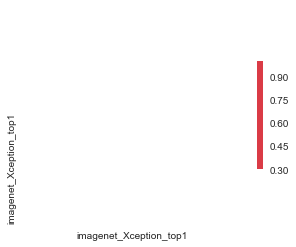

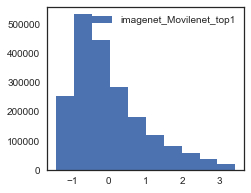

(2011862, 1)
Memory usage of dataframe is 30.70 MB
Memory usage after optimization is: 23.02 MB
Decreased by 25.0%
(2011862, 162)
1216.4311485290527  MB


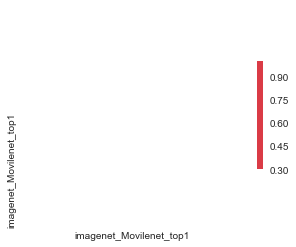

In [20]:
# imagenet
# Resnet50
df = loadfeather('../features/train/imagenet_Resnet50_train.feather', '../features/test/imagenet_Resnet50_test_debug.feather')
usecol = ['imagenet_Resnet50_top1']
df = df[usecol]
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

# Inception V3
df = loadfeather('../features/train/imagenet_IndeptionV3_train.feather', '../features/test/imagenet_IndeptionV3_test_debug.feather')
usecol = ['imagenet_IndeptionV3_top1']
df = df[usecol]
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

# Xception
df = loadfeather('../features/train/imagenet_Xception_train.feather', '../features/test/imagenet_Xception_test_debug.feather')
usecol = ['imagenet_Xception_top1']
df = df[usecol]
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

# Mobilenet
df = loadfeather('../features/train/imagenet_Movilenet_train_debug.feather', '../features/test/imagenet_Movilenet_test_debug.feather')
usecol = ['imagenet_Movilenet_top1']
df = df[usecol]
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

In [21]:
# Create fulldata

train = dfmaster[:lentrain]
test = dfmaster[lentrain: lentrain+lentest]

print(train.shape)
print(test.shape)

train.to_feather('../features/featured/train_full_6.feather')
test.to_feather('../features/featured/test_full_6.feather')

del train, test; gc.collect()
categorical


(1503424, 162)
(508438, 162)


['user_id',
 'region',
 'city',
 'parent_category_name',
 'category_name',
 'user_type',
 'image_top_1',
 'param_1',
 'param_2',
 'param_3']

In [22]:
# Create Reduced data
'''
train = dfmaster[:lentrain]
test = dfmaster[lentrain: lentrain+lentest]

res = get_smalldiff(train, test, userate=0.6)
train = train[res]
test = test[res]

print(train.shape)
print(test.shape)

train.to_feather('../features/featured/train_reduced.feather')
test.to_feather('../features/featured/test_reduced.feather')

categorical_ex1 = [col for col in train.columns if col in categorical]
del train, test; gc.collect()
categorical_ex1
'''


"\ntrain = dfmaster[:lentrain]\ntest = dfmaster[lentrain: lentrain+lentest]\n\nres = get_smalldiff(train, test, userate=0.6)\ntrain = train[res]\ntest = test[res]\n\nprint(train.shape)\nprint(test.shape)\n\ntrain.to_feather('../features/featured/train_reduced.feather')\ntest.to_feather('../features/featured/test_reduced.feather')\n\ncategorical_ex1 = [col for col in train.columns if col in categorical]\ndel train, test; gc.collect()\ncategorical_ex1\n"

In [23]:
# Create Reduced data
'''
train = dfmaster[:lentrain]
test = dfmaster[lentrain: lentrain+lentest]

res = get_smalldiff(train, test, userate=0.3)
train = train[res]
test = test[res]

print(train.shape)
print(test.shape)

train.to_feather('../features/featured/train_reduced_more.feather')
test.to_feather('../features/featured/test_reduced_more.feather')

categorical_ex2 = [col for col in train.columns if col in categorical]
del train, test; gc.collect()
categorical_ex2
'''


"\ntrain = dfmaster[:lentrain]\ntest = dfmaster[lentrain: lentrain+lentest]\n\nres = get_smalldiff(train, test, userate=0.3)\ntrain = train[res]\ntest = test[res]\n\nprint(train.shape)\nprint(test.shape)\n\ntrain.to_feather('../features/featured/train_reduced_more.feather')\ntest.to_feather('../features/featured/test_reduced_more.feather')\n\ncategorical_ex2 = [col for col in train.columns if col in categorical]\ndel train, test; gc.collect()\ncategorical_ex2\n"

In [24]:
dfmaster.head()

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,item_seq_number,...,imagefeatures__blurrness,imagefeatures__average_red,imagefeatures__average_green,imagefeatures__average_blue,imagefeatures__width,imagefeatures__height,imagenet_Resnet50_top1,imagenet_IndeptionV3_top1,imagenet_Xception_top1,imagenet_Movilenet_top1
0,884270,19,462,4,42,249,112,1217,-0.677024,-1.297002,...,-0.432018,-0.278210,-0.634123,0.686001,-0.150559,0.758586,-1.593788,-3.098809,-2.640898,0.408558
1,227908,17,1314,2,22,122,112,1217,0.053957,-0.300643,...,0.243387,-0.605289,-0.391314,-0.264190,-0.137390,0.758586,-1.168998,0.468036,-0.113284,0.790422
2,576261,16,1290,0,2,84,112,1217,0.158324,-0.664681,...,-0.292642,1.483807,1.375924,1.138331,0.073317,-0.177207,0.385052,0.466027,0.736486,-0.517972
3,755087,21,950,4,42,38,112,1217,-0.058564,1.098347,...,-0.465948,2.247374,2.125277,1.848744,-0.137390,-0.177207,-0.649074,0.468036,0.522710,-0.929891
4,944363,4,318,6,0,278,124,46,0.993673,-1.145913,...,-0.209743,0.176595,0.376505,0.051739,1.706301,-0.177207,0.426342,0.330671,-1.615118,-0.670591


In [25]:
dfmaster.columns[20:50]

Index(['avg_days_up_user', 'avg_times_up_user', 'avg_headdays_up_user',
       'n_user_items', 'avg_price_up_user', 'var_price_up_user',
       'title_titleword_count', 'title_upper_case_word_count',
       'title_num_stopwords', 'title_num_punctuations', 'title_num_chars',
       'title_chars_by_words', 'title_words_by_uniquewords',
       'title_punctuations_by_chars', 'title_punctuations_by_words',
       'title_stopwords_by_words', 'title_mean', 'description_titleword_count',
       'description_upper_case_word_count', 'description_num_stopwords',
       'description_num_punctuations', 'description_num_chars',
       'description_chars_by_words', 'description_words_by_uniquewords',
       'description_punctuations_by_chars',
       'description_punctuations_by_words', 'description_stopwords_by_words',
       'description_mean', 'title_description_len_ratio',
       'category_name-user_type_numunique'],
      dtype='object')